# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Импорты

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn import utils

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

### Функции

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
def distribution_overview(dFrame, attribute, title, scale=0.028, bns=None):
    mean = round(dFrame[attribute].mean(), 2)
    median = dFrame[attribute].median()
    mode = dFrame[attribute].mode()[0]
    min = dFrame[attribute].min()
    max = dFrame[attribute].max()
    q25 = dFrame[attribute].quantile(0.25)
    q75 = dFrame[attribute].quantile(0.95)
    q01 = dFrame[attribute].quantile(0.005)
    q99 = dFrame[attribute].quantile(0.995)

    plt.figure(figsize = (12, 8))
    sns.distplot(dFrame.loc[dFrame[attribute].notnull(), attribute], bins=bns)

    y = np.linspace(0, scale, 100)
    plt.plot([mean]*100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([median]*100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([mode]*100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title(title)
    plt.legend()

    print(f'min: {min}, quantile 0,01: {q01}, quantile 0,25: {q25}, mean: {mean}, median: {median}, mode: {mode}, quantile 0,75: {q75}, quantile 0,99: {q99}, max: {max}')

    plt.show()

### Описание датасета

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Файло

In [4]:
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
TEST_DATASET_PATH = 'test.csv'

In [6]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [7]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [8]:
DF_TEST_RESULT_DATASET_PATH = 'df_test_res.csv'

In [9]:
TRAIN_DATASET_PATH_ADD = 'df_add.csv'

In [10]:
TEST_DATASET_PATH_ADD = 'df_test_add.csv'

### Загрузка тренировочного набора

In [11]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Приведение типов данных

In [12]:
df.shape

(10000, 20)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [14]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [15]:
df['Rooms'].dtype

dtype('float64')

In [16]:
df['Rooms'] = df['Rooms'].astype('int64')

In [17]:
df['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [18]:
df['HouseFloor'].dtype

dtype('float64')

In [19]:
df['HouseFloor'] = df['HouseFloor'].astype('int64')

In [20]:
df['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [21]:
df['KitchenSquare'].dtype

dtype('float64')

In [22]:
df['KitchenSquare'] = df['KitchenSquare'].astype('int64')

In [23]:
df['KitchenSquare'].dtype

dtype('int64')

### Статистика

In [24]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор количественных переменных

In [25]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Обзор номинативных переменных

In [26]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [27]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [28]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [29]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка пропусков

In [40]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [38]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

Series([], Name: Rooms, dtype: int64)

In [39]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

Series([], Name: HouseYear, dtype: int64)

In [33]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        for floor in df['HouseFloor'][df['LifeSquare'].isnull()].unique():
            df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year) & (df['HouseFloor'] == floor), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year) & (df['HouseFloor'] == floor)].median()

In [34]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [35]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull()].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [42]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [43]:
values = sorted(values)

In [44]:
length = len(values)

In [45]:
length

79

In [46]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [47]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [48]:
b = df.loc[df['Healthcare_1'].isnull()]

In [49]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [50]:
df['Ecology_2'].mode()[0]

'B'

In [51]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [52]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

**Ecology_3**

In [53]:
df['Ecology_3'].mode()[0]

'B'

In [54]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [55]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

**Shops_2**

In [56]:
df['Shops_2'].mode()[0]

'B'

In [57]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [58]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

In [59]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,39.495823,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1246.040900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,77.151686,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1109.717391,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,23.811124,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,35.704183,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,47.015242,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1894.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Почти все признаки имеют выбросы.

In [60]:
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,B,B,33,7976,5,32.0,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3,80.384479,46.683720,12,5,17,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2,62.254114,37.160377,7,3,5,1960,0.460556,B,B,20,4386,14,2857.0,1,5,B,296021.204377
7,11993,74,2,80.312926,37.038420,0,14,0,1977,0.075779,B,B,6,1437,3,705.0,0,2,B,221244.156664
8,5172,1,2,64.511437,61.478074,1,9,17,1977,0.007122,B,B,1,264,0,4508.0,0,1,B,229102.795999
9,8649,23,1,46.461409,18.915552,8,13,17,2014,0.075779,B,B,6,1437,3,2078.0,0,2,B,95380.220993


In [61]:
df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9990,15233,1,3,57.373889,39.688445,5,2,5,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.542987
9991,11553,3,3,101.622794,51.628780,12,18,17,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504
9992,14333,150,3,78.249637,49.385096,10,5,16,1976,0.300323,B,B,52,10311,6,2729.0,1,9,B,342418.758888
9993,48,13,3,80.631333,48.899083,10,11,14,1999,0.090799,B,B,74,19083,2,4849.0,5,15,B,350684.628560
9994,4158,23,2,64.864198,61.478074,1,17,17,1977,0.075779,B,B,6,1437,3,830.0,0,2,B,171323.515653
9995,77,32,2,50.401785,30.476203,5,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9,13,13,2000,0.000000,B,B,30,5562,0,1786.0,0,5,A,189050.289571
9997,5123,27,1,47.939008,48.696782,1,12,16,2015,0.072158,B,B,2,629,1,540.0,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1,38.666645,21.157874,8,7,17,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


**Районы (DistrictId)**

In [65]:
df.sort_values(by="DistrictId", inplace=True)

In [66]:
DistrictId_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'DistrictId_Price':list(df.loc[df['Price'].notnull(), 'DistrictId'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 0.0, quantile 0,01: 3.1017584349748543e-06, quantile 0,25: 7.809895068987761e-05, mean: 0.0, median: 0.0001988650931393187, mode: 0.0, quantile 0,75: 0.0006745874999237103, quantile 0,99: 0.0012743769666656286, max: 0.0027145908018226333


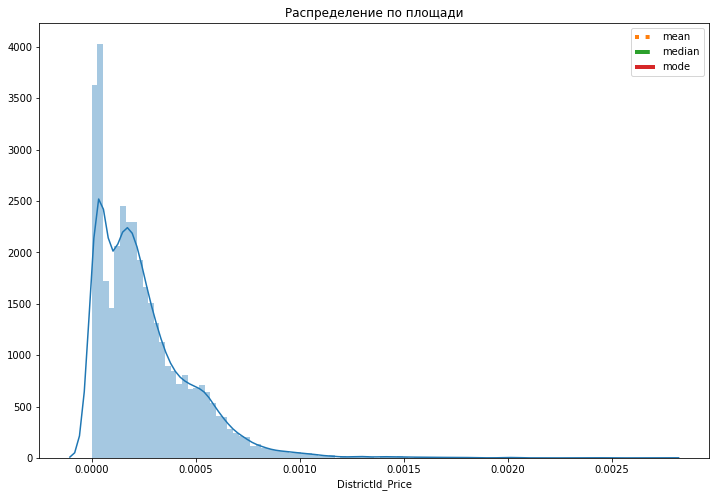

In [67]:
distribution_overview(DistrictId_Price, 'DistrictId_Price', 'Распределение по площади', 0.0062, 100)

In [68]:
id_list = list(DistrictId_Price.loc[DistrictId_Price['DistrictId_Price'] > 0.001, 'Id'])

In [69]:
df.loc[df['Id'].isin(id_list), 'DistrictId'].value_counts()

187    7
99     5
164    4
119    3
165    3
      ..
177    1
103    1
173    1
171    1
189    1
Name: DistrictId, Length: 65, dtype: int64

In [70]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4739,12676,81,3,13.784865,15.988889,7,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
3544,579,84,2,45.301564,28.938437,5,3,5,1961,0.006076,B,B,30,5285,0,645.0,6,6,B,63136.859879
1034,13715,91,2,41.881139,25.494645,7,6,9,1970,0.000995,B,B,42,7651,1,370.0,1,5,B,62483.977998
6024,6128,92,2,56.084601,34.380524,8,6,14,1999,0.460556,B,B,20,4386,14,1994.0,1,5,B,90471.540918
8124,13204,93,1,68.218458,64.800783,1,3,9,2013,0.012522,B,B,2,507,0,1450.0,0,0,B,86540.216330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,3656,192,1,35.638404,24.736845,5,11,9,1965,0.225825,A,B,41,6558,7,1548.0,3,2,B,137505.343314
9520,4050,193,2,46.034264,33.918107,5,4,5,1966,0.319809,B,B,25,4756,16,2857.0,5,8,B,181025.397125
2384,11949,193,1,35.784271,20.656814,5,1,5,1969,0.319809,B,B,25,4756,16,2857.0,5,8,B,130500.697853
3714,12865,201,2,44.401451,26.027903,5,3,9,1967,0.081943,B,B,20,2738,20,2890.0,1,4,B,174216.778670


In [71]:
df.loc[df['Id'].isin(id_list), 'DistrictId'] = df['DistrictId'].median()

In [72]:
df.loc[df['DistrictId'].notnull(), 'DistrictId']

3497      0.0
8364      0.0
9516      0.0
1891      0.0
1841      0.0
        ...  
7553    205.0
3443    207.0
1210    208.0
2931    208.0
7650     36.0
Name: DistrictId, Length: 10000, dtype: float64

In [73]:
df.loc[df['DistrictId'].notnull(), 'DistrictId'].value_counts()

27.0     851
1.0      652
23.0     565
6.0      511
9.0      294
        ... 
193.0      1
158.0      1
205.0      1
207.0      1
117.0      1
Name: DistrictId, Length: 204, dtype: int64

min: 0.0, quantile 0,01: 1.0, quantile 0,25: 20.0, mean: 49.26, median: 36.0, mode: 27.0, quantile 0,75: 134.0, quantile 0,99: 187.0, max: 208.0


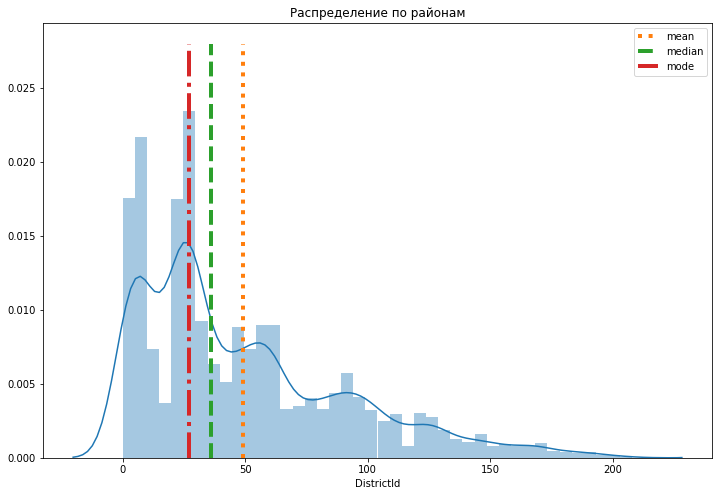

In [74]:
distribution_overview(df, 'DistrictId', 'Распределение по районам', 0.028)

Распределение по районам без особых выбросов.

**Распределение по комнатам (Rooms)**

In [75]:
df['Rooms'].unique()

array([ 1,  2,  3,  4, 19,  0,  5, 10,  6], dtype=int64)

In [76]:
df.sort_values(by="Rooms", inplace=True)

In [77]:
df.loc[df['Rooms'].notnull(), 'Rooms']

2269     0
4853     0
6149     0
3911     0
4366     0
        ..
5361     5
2170     6
377     10
8849    10
1454    19
Name: Rooms, Length: 10000, dtype: int64

In [78]:
df.loc[df['Rooms'].notnull(), 'Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

Есть выбросы для квартир к количеством комнат: 0, 6, 10, 19, 17

In [79]:
df.loc[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2269,7317,27.0,0,41.790881,0.873147,0,13,0,1977,0.211401,B,B,9,1892,0,2643.0,0,1,B,98129.976788
4853,3224,27.0,0,2.377248,0.873147,0,1,0,1977,0.017647,B,B,2,469,0,32.0,0,0,B,126596.941798
6149,3159,88.0,0,38.697117,19.345131,9,9,16,1982,0.127376,B,B,43,8429,3,1020.0,3,9,B,158998.110646
3911,770,28.0,0,49.483501,35.704183,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6.0,0,81.491446,0.873147,0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8834,9443,27.0,0,87.762616,85.125471,0,5,15,1977,0.211401,B,B,9,1892,0,2643.0,0,1,B,219281.918007
1397,12638,27.0,0,138.427694,136.215499,0,4,3,2016,0.075424,B,B,11,3097,0,125.0,0,0,B,268394.744389
1981,7917,27.0,0,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,620.0,0,1,B,302211.260887


In [80]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] < 45.0), 'Rooms'] = 1

In [81]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [82]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(65.0, 85.0), 'Rooms'] = 3

In [83]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(85.0, 105.0), 'Rooms'] = 4

In [84]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] > 106), 'Rooms'] = 5

In [85]:
df.loc[df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2170,14003,99.0,6,59.414334,38.702244,6,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [86]:
df.loc[(df['Rooms'] == 6) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [87]:
df.loc[(df['Rooms'] == 6) & (df['Square'] > 106), 'Rooms'] = 5

In [88]:
df.loc[df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57.0,10,59.056975,36.223072,10,22,22,2002,0.090799,B,B,74,19083,2,125.0,5,15,B,317265.323792
8849,14865,9.0,10,60.871266,38.420681,10,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [89]:
df.loc[df['Rooms'] == 10, 'Rooms'] = 2

In [90]:
df.loc[df['Rooms'] == 19]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1.0,19,42.006046,21.779288,7,17,17,2014,0.007122,B,B,1,264,0,200.0,0,1,B,78364.616704


In [91]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

In [92]:
df.loc[df['Rooms'] == 17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [93]:
df.loc[df['Rooms'] == 17, 'Rooms'] = 2

In [94]:
df['Rooms'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

min: 1, quantile 0,01: 1.0, quantile 0,25: 1.0, mean: 1.89, median: 2.0, mode: 2, quantile 0,75: 3.0, quantile 0,99: 4.0, max: 5


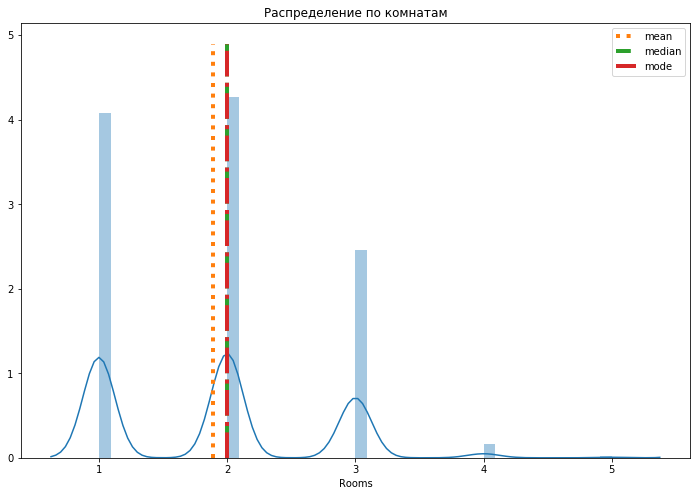

In [95]:
distribution_overview(df, 'Rooms', 'Распределение по комнатам', 4.9)

**Общая площадь квартиры (Square)**

In [96]:
df.sort_values(by="Square", inplace=True)

In [97]:
Square_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'Square_Price':list(df.loc[df['Price'].notnull(), 'Square'] / df.loc[df['Price'].notnull(), 'Price'])})

min: 4.339081178854126e-06, quantile 0,01: 0.00012288337125399384, quantile 0,25: 0.0002131116523673229, mean: 0.0, median: 0.0002557510524445752, mode: 4.339081178854126e-06, quantile 0,75: 0.0005004050902978822, quantile 0,99: 0.0008064387505898329, max: 0.004800919055939031


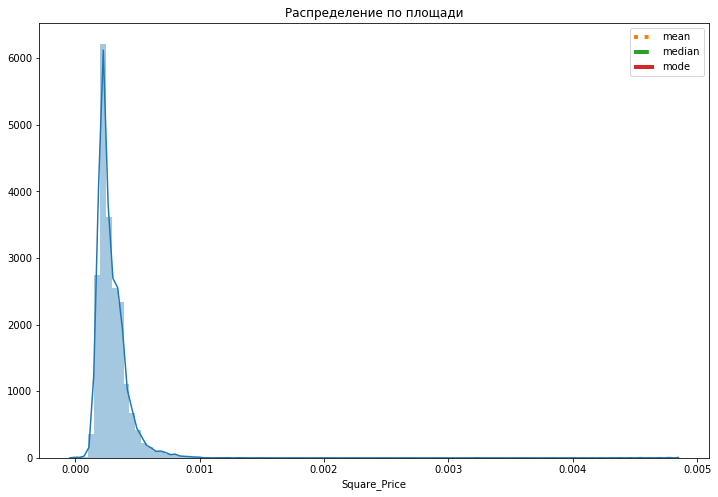

In [98]:
distribution_overview(Square_Price, 'Square_Price', 'Распределение по площади', 0.0062, 100)

In [99]:
id_list = list(Square_Price.loc[Square_Price['Square_Price'] > 0.0008, 'Id'])

In [100]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9732,13237,36.0,2,51.726692,30.547287,8,2,14,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
9705,11560,11.0,2,52.685729,34.636558,5,10,9,1973,0.000170,B,B,36,5992,0,370.0,1,1,B,65343.643530
1622,11854,9.0,2,55.126426,29.914386,8,4,14,2004,0.130123,B,B,8,1986,0,2715.0,0,0,B,62126.665619
5813,8935,47.0,2,55.369224,30.587406,9,17,17,2010,0.197368,B,B,8,2423,1,32.0,0,1,B,66722.596920
522,671,23.0,2,55.869625,54.177713,10,3,17,2015,0.005767,B,B,1,388,0,30.0,0,0,B,63900.205590
3605,7243,9.0,2,58.089253,52.460857,8,5,22,1981,0.136244,B,B,11,2370,0,1046.0,0,1,B,59877.592523
3128,8823,7.0,2,59.466919,33.746589,9,18,16,2016,0.130618,B,B,39,10418,9,900.0,1,9,B,71291.546163
1884,7439,27.0,2,61.342410,33.767600,12,3,17,2014,0.072158,B,B,2,629,1,1020.0,0,0,A,67343.133878
2410,16148,19.0,2,61.464284,30.289514,13,9,15,2009,0.309479,B,B,35,7715,4,990.0,0,6,B,72430.588440
2413,9000,41.0,2,61.511547,32.941861,12,13,14,2010,0.175055,B,B,36,10055,3,900.0,1,0,B,75269.221823


In [101]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Жилая площадь (LifeSquare)**

In [111]:
def handle_emissions(dframe, attribute, title, scale=0.028, bns=None):
    field = title + '_Price'
    dframe.sort_values(by=attribute, inplace=True)
    result_data_set = pd.DataFrame({'Id':list(dframe.loc[dframe['Price'].notnull(), 'Id']), 'Value':list(dframe.loc[dframe['Price'].notnull(), attribute] / dframe.loc[dframe['Price'].notnull(), 'Price'])})
    distribution_overview(result_data_set, 'Value', title, scale, bns)
    dframe.loc[dframe['Id'].isin(id_list)]
    for id in id_list:
        rooms = list(dframe['Rooms'][dframe['Id'] == id])[0]
        floor = list(dframe['HouseFloor'][dframe['Id'] == id])[0]
        result = dframe[attribute][(dframe['Rooms'] == rooms) & (dframe['HouseFloor'] == floor) & (dframe['HouseYear'] != 1977)].median()
        if pd.notnull(result):
            dframe.loc[dframe['Id'] == id, attribute] = round(result,0)
            
    result_data_set_res = pd.DataFrame({'Id':list(dframe.loc[dframe['Price'].notnull(), 'Id']), 'Value':list(dframe.loc[dframe['Price'].notnull(), attribute] / dframe.loc[dframe['Price'].notnull(), 'Price'])})
    distribution_overview(result_data_set_res, 'Value', title, scale, bns)

min: 1.9028234778410429e-06, quantile 0,01: 9.278537198807874e-06, quantile 0,25: 0.00012632657678416593, mean: 0.0, median: 0.0001604654150845087, mode: 1.9028234778410429e-06, quantile 0,75: 0.0004156645012175409, quantile 0,99: 0.0006319276240475569, max: 0.03441607670151886


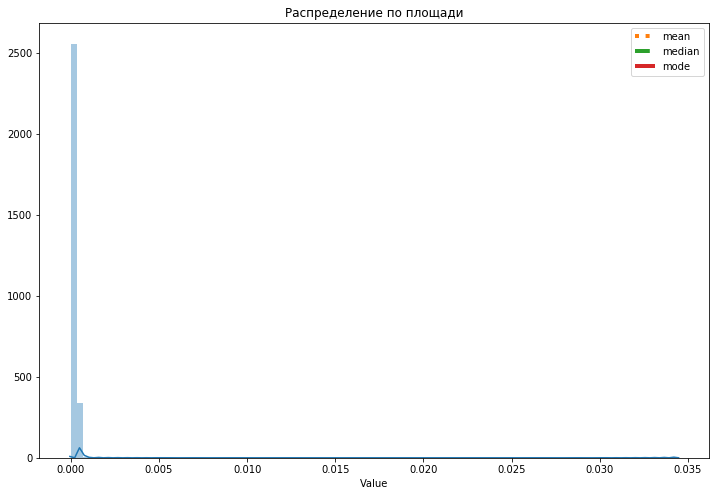

min: 1.9028234778410429e-06, quantile 0,01: 9.278537198807874e-06, quantile 0,25: 0.00012632657678416593, mean: 0.0, median: 0.0001604654150845087, mode: 1.9028234778410429e-06, quantile 0,75: 0.0004156645012175409, quantile 0,99: 0.0006319276240475569, max: 0.03441607670151886


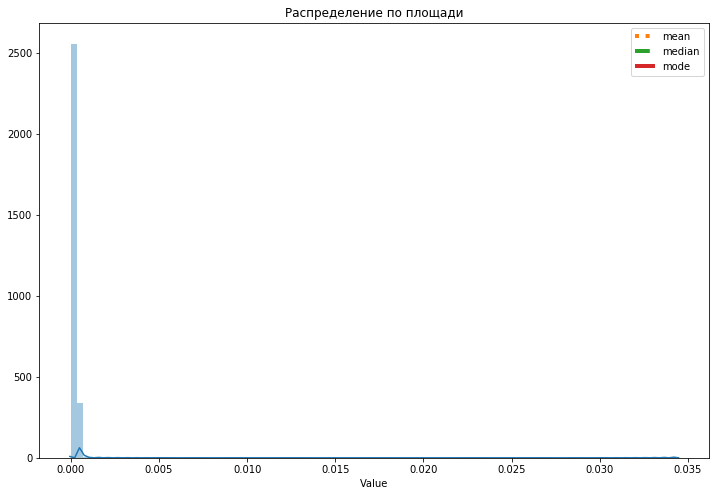

In [112]:
handle_emissions(df, 'LifeSquare', 'Распределение по площади', 0.0062, 100)

In [ ]:
df.sort_values(by="LifeSquare", inplace=True)

In [ ]:
LifeSquare_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'LifeSquare_Price':list(df.loc[df['Price'].notnull(), 'LifeSquare'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
distribution_overview(LifeSquare_Price, 'LifeSquare_Price', 'Распределение по площади', 0.0062, 100)

In [ ]:
id_list = list(LifeSquare_Price.loc[LifeSquare_Price['LifeSquare_Price'] > 0.0005, 'Id'])

In [ ]:
df.loc[df['Id'].isin(id_list)]

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['LifeSquare'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'LifeSquare'] = round(result,0)

**Кухня (KitchenSquare)**

In [ ]:
df.sort_values(by="KitchenSquare", inplace=True)

In [ ]:
KitchenSquare_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'KitchenSquare_Price':list(df.loc[df['Price'].notnull(), 'KitchenSquare'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
distribution_overview(KitchenSquare_Price, 'KitchenSquare_Price', 'Распределение по площади', 0.0062, 100)

In [ ]:
id_list = list(KitchenSquare_Price.loc[KitchenSquare_Price['KitchenSquare_Price'] > 0.0001, 'Id'])

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['KitchenSquare'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'KitchenSquare'] = round(result,0)

**Этаж (Floor)**

In [ ]:
df.sort_values(by="Floor", inplace=True)

In [ ]:
Floor_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'Floor_Price':list(df.loc[df['Price'].notnull(), 'Floor'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
distribution_overview(Floor_Price, 'Floor_Price', 'Распределение по площади', 0.0062, 100)

In [ ]:
id_list = list(Floor_Price.loc[Floor_Price['Floor_Price'] > 0.00018, 'Id'])

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Floor'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Floor'] = round(result,0)

**Этажность дома (HouseFloor)**

In [ ]:
df.sort_values(by="HouseFloor", inplace=True)

In [ ]:
HouseFloor_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'HouseFloor_Price':list(df.loc[df['Price'].notnull(), 'HouseFloor'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
distribution_overview(HouseFloor_Price, 'HouseFloor_Price', 'Распределение по площади', 0.0062, 100)

In [ ]:
id_list = list(HouseFloor_Price.loc[HouseFloor_Price['HouseFloor_Price'] > 0.0002, 'Id'])

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    result = df['HouseFloor'][(df['Rooms'] == rooms) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseFloor'] = round(result,0)

**Год постройки (HouseYear)**

In [ ]:
df.sort_values(by="HouseYear", inplace=True)

In [ ]:
HouseYear_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'HouseYear_Price':list(df.loc[df['Price'].notnull(), 'HouseYear'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
distribution_overview(HouseYear_Price, 'HouseYear_Price', 'Распределение по площади', 0.0062, 100)

In [ ]:
id_list = list(HouseYear_Price.loc[HouseYear_Price['HouseYear_Price'] > 0.029, 'Id'])

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['HouseYear'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseYear'] = round(result,0)

In [ ]:
df.sort_values(by="Price", inplace=True)

In [ ]:
Square_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'Square_Price':list(df.loc[df['Price'].notnull(), 'Square'] / df.loc[df['Price'].notnull(), 'Price'])})

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(list(Square_Price.loc[Square_Price['Square_Price'].notnull(), 'Square_Price']), list(df.loc[df['Price'].notnull(), 'Price']))

### Отбор и построение новых признаков

In [ ]:
df.sort_values(by="Id", inplace=True)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [ ]:
# df.drop(['Id'],axis=1,inplace=True)

In [ ]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [ ]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [ ]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [ ]:
df.head()

Разобъем обратно набор данных df на 2 набора: тренировочный м икчирвый.

In [ ]:
df_train = df.loc[df['Price'].notnull()]

In [ ]:
df_test = df.loc[df['Price'].isnull()]

Сохраним эти наборы.

In [ ]:
df.to_csv(DF_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [ ]:
df_test.to_csv(DF_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [ ]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

target_mean, target_median, target_mode

In [ ]:
plt.figure(figsize = (12, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [ ]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

In [ ]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

In [ ]:
# sns.pairplot(df_num_features);

In [ ]:
# grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [ ]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

In [ ]:
# grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [ ]:
# grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [ ]:
# grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [ ]:
# grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

In [ ]:
# grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
# grid.fig.set_figwidth(12)
# grid.fig.set_figheight(12)

# plt.show()

### Отбор признаков

In [ ]:
df.columns.tolist()

In [ ]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']
target_name = 'Price'

In [ ]:
df = df[feature_names + [target_name]]
df.head()

### Стандартизация признаков

In [ ]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

In [ ]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [ ]:
stand_features

In [ ]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [ ]:
df.head()

### Сохранение обучающего датасета

In [ ]:
df.to_csv(TRAIN_DATASET_PATH_ADD, index=False, encoding='utf-8')

### Разбиение на train и test

In [ ]:
X = df[feature_names]
y = df[target_name]

In [ ]:
len(X) - X.count()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [ ]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
# sorted(y_train_preds)

In [ ]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
y_test_preds

In [ ]:
lasso_model = Lasso(alpha=0.3)
lasso_model.fit(X_train, y_train)

In [ ]:
y_train_preds = lasso_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(X_train, y_train)

In [ ]:
y_train_preds = ridge_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

In [ ]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

In [ ]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
X_train.dtypes

In [ ]:
y_train.dtypes

In [ ]:
# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_Y)

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_encoded)

In [ ]:
log_r_model = LogisticRegression(solver="liblinear")
log_r_model.fit(X_train, y_train_encoded)

In [ ]:
? LogisticRegression

In [ ]:
y_train_preds = log_r_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = log_r_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Загрузка тестового набора

In [ ]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

In [ ]:
test.shape

In [ ]:
test.info()

In [ ]:
test.dtypes

Количество комнат должно быть целым числом.

In [ ]:
test['Rooms'].dtype

In [ ]:
test['Rooms'] = test['Rooms'].astype('int64')

In [ ]:
test['Rooms'].dtype

Количество этажей целочисленное значение.

In [ ]:
test['HouseFloor'].dtype

In [ ]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [ ]:
test['HouseFloor'].dtype

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [ ]:
test['KitchenSquare'].dtype

In [ ]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [ ]:
test['KitchenSquare'].dtype

In [ ]:
X_test = df_test[feature_names]

In [ ]:
y_test_preds = rf_model.predict(X_test)

In [ ]:
y_test_preds

In [ ]:
df_res = pd.DataFrame({'Id':list(test['Id']),'Price':list(y_test_preds)})

In [ ]:
df_res.to_csv(DF_TEST_RESULT_DATASET_PATH, index=False, encoding='utf-8')